In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [3]:
from collections import Counter, defaultdict, OrderedDict, namedtuple
import copy

In [4]:
en_stopwords = set(stopwords.words('english'))

In [5]:
def not_stopword(word):
    return word.lower() not in en_stopwords

In [6]:
def not_all_punct(word):
    return not all([not c.isalnum() for c in word])

In [7]:
def to_lower(word):
    return word.lower()

In [8]:
snowball = SnowballStemmer('english')
def stemmer(word):
    return snowball.stem(word)

In [9]:
#parser_type = 'xml'
#parser_type = 'html.parser'
parser_type = 'lxml'
#parser_type = 'lxml-xml'
#parser_type = 'html5lib'

In [10]:
%%time
with open("data/allRecsWithAbstractsEscaped.xml") as f:
    full_data = BeautifulSoup(f, features=parser_type)

CPU times: user 4min 49s, sys: 1min 30s, total: 6min 19s
Wall time: 6min 46s


In [11]:
def explore(tag, by_level=None, indent=0):
    if by_level is None:
        by_level = []
    if len(by_level) <= indent:
        by_level.append(set())
    by_level[indent].add(tag.name)
    for c in tag.find_all(text=False, recursive=False):
        by_level = explore(c, by_level, indent=indent+1)
    return by_level

In [12]:
%%time
by_level = explore(full_data.records)

for level_index, tags in enumerate(by_level):
    print '  '*level_index + u', '.join(sorted(list(tags)))

records
  record
    abstract, identifier, subject, title
CPU times: user 3min 18s, sys: 32.5 s, total: 3min 51s
Wall time: 4min 4s


In [13]:
class Record(namedtuple("Record", ["title", "identifier", "abstract", "subjects"])):
    pass

In [14]:
len(full_data.records.find_all(text=False, recursive=False))

483052

In [15]:
def process_records(data, limit=None):
    result = []

    for r in data.records.find_all(text=False, recursive=False, limit=limit):
        if r.name != "record":
            raise Exception(u"Unexpected child node of records: {} != record".format(r.name))

        title = unicode(r.title.string)
        abstract = unicode(r.abstract.string)
        subjects = [unicode(x.string) for x in r.find_all("subject", recursive=False)]
        identifier = unicode(r.identifier.string)

        r_obj = Record(title=title, identifier=identifier, abstract=abstract, subjects=subjects)
        result.append(r_obj)

    return result

In [16]:
%%time
record_objects = process_records(data = full_data, limit = None)
print len(record_objects)

483052
CPU times: user 2min 56s, sys: 32.1 s, total: 3min 28s
Wall time: 3min 44s


In [17]:
auto_cleanup = True

In [18]:
if auto_cleanup:
    print "Cleaning up bs4 objects"
    full_data.decompose()
    del full_data
else:
    print "NOT cleaning up"

Cleaning up bs4 objects


In [19]:
class MyTokenizer(object):
    def __init__(self,
            transforms=None,
            filters=None,
            word_tokenizer=None,
            sent_tokenizer=None):

        if transforms is None:
            transforms = []
        if word_tokenizer is None:
            word_tokenizer = word_tokenize
        if filters is None:
            filters = []
        self.word_tokenizer = word_tokenizer
        self.sent_tokenizer = sent_tokenizer
        self.filters = filters
        self.transforms = transforms

    def tokenize(self, str_to_tokenize):
        if self.sent_tokenizer is None:
            sentences = [str_to_tokenize]
        else:
            sentences = self.sent_tokenizer(str_to_tokenize)

        tokens_by_sentence = []
        for sent in sentences:
            tokens = []
            for t in self.word_tokenizer(sent):
                include_token = all(f(t) for f in self.filters)
                if include_token:
                    transformed = t
                    for tr in self.transforms:
                        transformed = tr(t)
                    tokens.append(transformed)
                    
            tokens_by_sentence.append(tokens)

        if self.sent_tokenizer is None:
            return tokens_by_sentence[0]
        else:
            return tokens_by_sentence

In [20]:
tokenizer = MyTokenizer(
    filters = [not_all_punct, not_stopword],
    transforms = [to_lower, stemmer],
    word_tokenizer = word_tokenize,
    sent_tokenizer = None)

In [152]:
%%time

all_subjects = set()
stats_by_document = []

do_tokens = False

rec_count = 0
for r in record_objects:
    stats_by_document.append(OrderedDict([
        ('abstract_length_chars', len(r.abstract) if r.abstract is not None else 0),
        ('num_subjects', len(r.subjects)),
    ]))

    all_subjects |= set(r.subjects)

    if do_tokens and r.abstract is not None:
        tokens = tokenizer.tokenize(r.abstract)
    else:
        tokens = []

    if rec_count < 5:
        print(u"=============")
        print(u"Title: {}".format(r.title))
        print(u"Abstract: {}".format(r.abstract))
        print(u"Subjects ({}): {}".format(len(r.subjects), u"; ".join(r.subjects)))
        print(u"Tokens: {}".format(tokens))

    rec_count += 1

all_subjects = sorted(list(all_subjects))
stats_by_document = pd.DataFrame.from_records(stats_by_document)

Title: DVIEW
Abstract: DView is a time series data visualization tool that provides several different ways to plot time series datasets. It is particularly well suited for browsing the results of energy systems simulation programs such as BeOpt, SAM, and PVWatts.
Subjects (0): 
Tokens: []
Title: LK Scripting Language
Abstract: The LK scripting language is a simple and fast computer programming language designed for easy integration with existing software to enable automation of tasks.
Subjects (0): 
Tokens: []
Title: Parallel Planes Information Visualization
Abstract: This software presents a user-provided multivariate dataset as an interactive three dimensional visualization so that the user can explore the correlation between variables in the observations and the distribution of observations among the variables.
Subjects (0): 
Tokens: []
Title: Retrospective Mobility Analysis
Abstract: An application that provides users with ex post information on foregone travel conclusions to induc

In [153]:
print(u"Total number of records: {}".format(rec_count))
print(u"Total number of subjects: {}".format(len(all_subjects)))

Total number of records: 483052
Total number of subjects: 26862


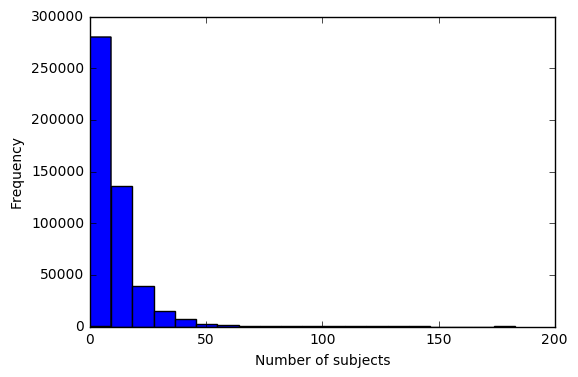

In [154]:
fig, ax = plt.subplots()
ax.hist(stats_by_document["num_subjects"], bins=20)
ax.set_xlabel('Number of subjects')
ax.set_ylabel('Frequency')
None

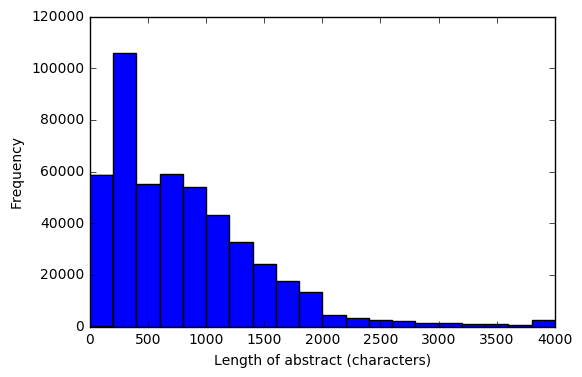

In [155]:
fig, ax = plt.subplots()
ax.hist(stats_by_document["abstract_length_chars"], bins=20)
ax.set_xlabel('Length of abstract (characters)')
ax.set_ylabel('Frequency')
None

In [156]:
u_subjects = np.sort(np.unique(all_subjects))

In [157]:
len(u_subjects)

26862

In [174]:
len(record_objects)

483052

In [175]:
%%time
n_subj = len(u_subjects)
unions = np.zeros((n_subj, n_subj))
intersects = np.zeros((n_subj, n_subj))

s_count = 0
s_ones = np.ones((n_subj,))
for rec_index, r in enumerate(record_objects):
    if rec_index % 10000 == 0:
        print rec_index
    s_ind = [np.asscalar(np.where(u_subjects == s)[0]) for s in r.subjects]
    s_ind_set = set(s_ind)
    for i in s_ind_set:
        unions[i, :] += s_ones
        unions[:, i] += s_ones
        for j in s_ind_set:
            intersects[i, j] += 1
            unions[i, j] -= 1  # remove double-counting

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
CPU times: user 2h 37min 30s, sys: 1min, total: 2h 38min 31s
Wall time: 2h 41min 21s


In [176]:
%%time
distances = 1.0 - np.true_divide(intersects, unions)
distances[np.isnan(distances)] = 1.0

CPU times: user 6.56 s, sys: 23.1 s, total: 29.7 s
Wall time: 43.1 s


In [177]:
np.min(distances), np.max(distances)

(0.0, 1.0)

In [178]:
distances.shape

(26862, 26862)

In [179]:
distances.nbytes

5772536352

In [180]:
%%time
np.savez_compressed(file = "data/distances.npz", distances = distances)

CPU times: user 35.1 s, sys: 11.8 s, total: 46.9 s
Wall time: 51.4 s


In [181]:
%%time
d = np.load(file = "data/distances.npz")["distances"]

CPU times: user 6.46 s, sys: 2.36 s, total: 8.82 s
Wall time: 9.54 s


In [182]:
print d.nbytes
print d.shape

5772536352
(26862, 26862)
